# Time Series Using ARIMA



## Problem Statement

Perform Time Series Analysis with ARIMA forecasting model on US Airline Passengers dataset.

##  Objectives


* understand the time series and its stationarity
* understand the AR and MA terms
* perform Time Series Analysis with ARIMA Forecasting model
* understand SARIMA Forecasting model

## Dataset

The dataset chosen for this experiment is  AirPassengers. This dataset provides monthly totals of US airline passengers from 1949 to 1960.

## Information

**Auto Regressive (AR)** model is a specific type of regression model where the dependent variable depends on past values of itself.
This necessarily means that the current values are correlated with values in the previous time-steps. And more specifically, the type of correlation here is partial auto-correlation. The equation for the AR model is shown below.

$Y_t = \beta_1 + \Phi_1 Y_{t-1} + \Phi_2 Y_{t-2}+...+\Phi_p Y_{t-p}$

The respective weights(Ф1, Ф2 …Фp) of the corresponding lagged observations are decided by the correlation between… that lagged observation and the current observation. If the correlation is more, the weight corresponding to that lagged observation is high (and vice-versa).

Notice the (p) in the equation is called the lag order. It represents the number of prior lag observations we include in the model i.e. the number of lags which have a significant correlation with the current observation.

**Moving Average (MA)** model works by analyzing how wrong we were in predicting values for the previous time periods to make a better estimate for the current time period. This model factors in errors from the lagged observations. The effects of these previous(lagged) observation errors, on the current observation, depend on the auto-correlation between them. This is similar in the sense to the AR model which considers the partial auto-correlations.

$Y_t = \beta_2 + \omega_1 \varepsilon_{t-1} + \omega_2 \varepsilon_{t-2} + ...+\omega_q \varepsilon_{t-q}+\varepsilon_t$

The ε terms represent the errors observed at respective lags and the weights (ω1,ω2 …ωq) are calculated statistically depending on the correlations. Notice the (q) in the equation represents the size of the moving window i.e. the number of lag observation errors which have a significant impact on the current observation. It is similar to the lag order(p), but it considers errors instead of the observations themselves.

MA model supplements the AR model by taking into consideration, the errors from the previous time periods thereby helping to get a better estimate.
When we combine the AR and MA equation we get

$Y_t = (\beta_1 + \beta_2) + (\Phi_1 Y_{t-1})+...+(\Phi_p Y_{t-p}) + (\omega_1 \varepsilon_{t-1}+...+\omega_q \varepsilon_{t-q}+\varepsilon_t)$

Integrating AR and MA, the final ARIMA model will take the following form.

**ARIMA(p,d,q)** where, p = lag order, d = order of differencing, q = moving avergae window.

**Task Flow:**

Observation of trends, seasonality, and noise

Making a Time Series Stationary

Forecasting Model -ARIMA

In [ ]:
#@title Download Dataset
!wget -qq https://cdn.iisc.talentsprint.com/aiml/Experiment_related_data/AirPassengers.csv

### Import required Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
# import necessary files for SARIMA model
import statsmodels.api as sm

### Load the Data

In [ ]:
# Read the AirPassengers dataset
data = pd.read_csv('AirPassengers.csv',  parse_dates = True)
data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
# Convert Month object into datetime
data['Month'] = pd.to_datetime(data.Month)
data.set_index('Month', inplace=True)
df = data.sort_index(axis=0)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### Identify the trends and seasonality from the given time series data

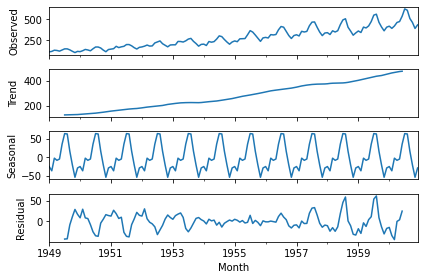

In [ ]:
ts = data['Passengers']
# Decomposition time series
result = seasonal_decompose(ts)
result.plot();

The seasonal decompose method broke down the data into three parts: trend,
seasonality and residual components.

**Trend** – varying mean over time. **For eg.,** the number of passengers is seen to be growing over time.

**Seasonality** – variations in specific time-frames. **For eg.,** people may travel more in specific months owing to holidays/festivals.

**Residual Component (noise)** - We can see from the plot that there appears to be randomness in the data.

### Check for Time Series Stationarity

Perform Rolling Statistics to ensure whether the time series is stationary or not.

**Rolling Statistics:** Plot the rolling mean and rolling standard deviation. The time series is stationary if they remain constant with time

For a time series to be stationary, it should satisfy the following 3 conditions
* Mean (μ) is constant
* Standard Deviation (σ) is constant
* Seasonality doesn’t exist


In [ ]:
# Let’s create a function to run the test which determines whether a given time series is stationary
def get_stationarity(timeseries):
    # Rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()

    # Rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

In [ ]:
# Show few rows of df
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


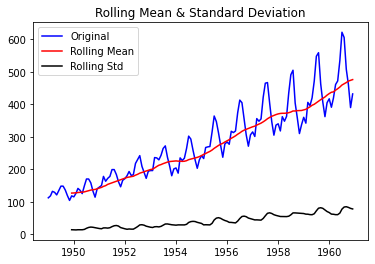

In [ ]:
# Check for stationarity
get_stationarity(df)

As we can see, the rolling mean and rolling standard deviation increase with time. ***Therefore, it can be inferred that the time series is not stationary.***

### Make the time series stationary

Stationarity is important because many useful analytical tools and statistical tests and models rely on it.

- Apply transformations such as logarithms to stabilize the variance of a time series.
- Apply differencing to stabilize the mean of a time series by removing changes in the level of a time series, and therefore reducing (or eliminating) trend and seasonality.

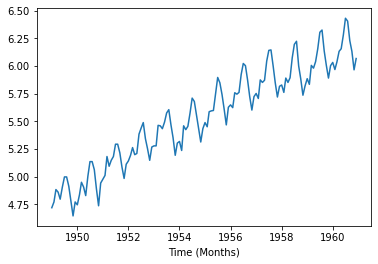

In [ ]:
# ESTIMATING THE TREND
# Applying a log transformation
df_log = np.log(df)
plt.plot(df_log)
plt.xlabel("Time (Months)")
plt.show()

Eliminating the Trend and Seasonality by **Differencing** (taking the difference with a particular time lag)

In [ ]:
# Differencing
shift_df = pd.concat([df_log, df_log.shift(1)],axis=1)
shift_df.columns = ['Actual_Passengers','Forecasted_Passengers']
shift_df.head()

,Actual_Passengers,Forecasted_Passengers
Month,,
1949-01-01,4.718499,NaN
1949-02-01,4.770685,4.718499
1949-03-01,4.882802,4.770685
1949-04-01,4.859812,4.882802
1949-05-01,4.795791,4.859812


We create a lagged copy of the data by subtracting every previous data point from the current data point.

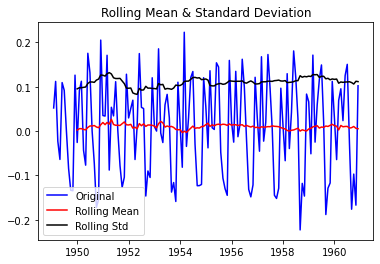

In [ ]:
# Taking the difference with a particular time lag
df_log_shift = shift_df['Actual_Passengers'] - shift_df['Forecasted_Passengers']
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

We can see that the mean and standard deviation are approximately horizontal. We can also take second or third order differences which might get even better results in certain applications. However, it is still more stationary than the original.

### Split the time series into training and testing data

In [ ]:
# Splitting the data into train and test sets
train_data, test_data = df_log[0:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]
train_data.size, test_data.size

(115, 29)

## Apply ARIMA Model

**ARIMA model (Autoregressive {p} Integrated {d} Moving Average {q})**

The model has 3 parameters:

* **p** - the parameter associated with the `Auto-Regressive part` of the ARIMA model.

* **d** - the parameter associated with the `Integration part` of the ARIMA model.

* **q** - the parameter associated with the `Moving Average part` of the ARIMA model.

### Visualize ACF and PACF plots to determine p, d and q

* **Order of difference (d)** is the number of times the time series is differenced in order to stationarize the series.

* Use the **PACF** (partial autocorrelation function) plot to find the optimal **p** value.

* Use the **ACF** (autocorrelation function) plot to find the optimal **q** value.



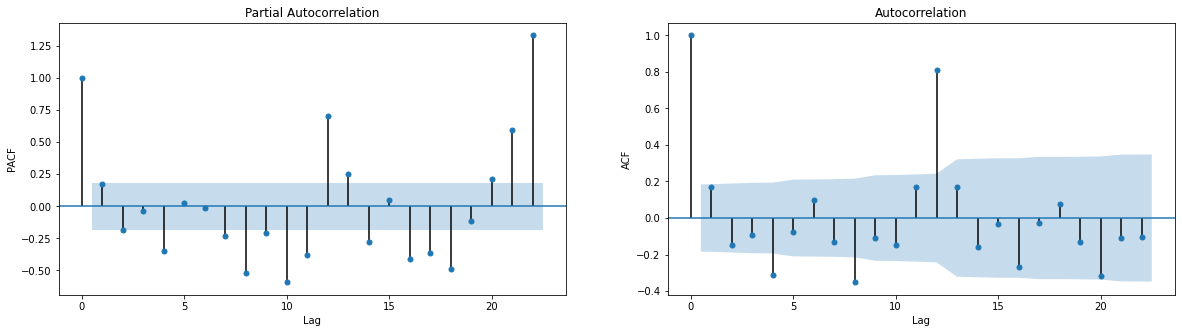

In [ ]:
# Visualize PACF and ACF plots
trainData_diff = train_data.diff().dropna()
fig, ax = plt.subplots(1,2, figsize =(20, 5))
fig = plot_pacf(trainData_diff, lags=22, ax=ax[0]);ax[0].set_xlabel("Lag");ax[0].set_ylabel("PACF");
fig = plot_acf(trainData_diff, lags=22, ax=ax[1]);ax[1].set_xlabel("Lag");ax[1].set_ylabel("ACF");
plt.show()

From the above PACF and ACF plots, we can see a sharp cut-off at lag-1 in both of the plots.

The [rules](https://people.duke.edu/~rnau/arimrule.htm) for identifying ARIMA models suggests:

* If the partial autocorrelation function (PACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive then consider adding one or more AR terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms.

* If the autocorrelation function (ACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative then consider adding an MA term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.

From the above points, we can select $p=0+1=1$ and $q=0+1=1$. Also, the differencing is done one time to achieve stationarity, so $d=1$.

### Train an ARIMA model

In [ ]:
# ARIMA model
train_ar = train_data['Passengers'].values
test_ar = test_data['Passengers'].values

history = [x for x in train_ar]

predictions = list()
for t in range(len(test_ar)):
    # create arima model with p, d, q
    model = ARIMA(history, order=(1,1,1))
    '''order = (1, 1, 1) indicates a lag value of 1 for autoregression, a difference order of 1 to make the time series stationary and a moving average model of 1'''
    model_fit = model.fit()
    # one-step forecast
    output = model_fit.forecast()
    yhat = output[0]
    # append forecast to predictions
    predictions.append(yhat)
    obs = test_ar[t]
    # append true observation for forecast to history
    history.append(obs)

# RMSE value for test data and its predictions
error = np.sqrt(mean_squared_error(test_ar, predictions))
print('RMSE value: %.3f' % error)

RMSE value: 0.115


### Visualize the predictions from ARIMA Model

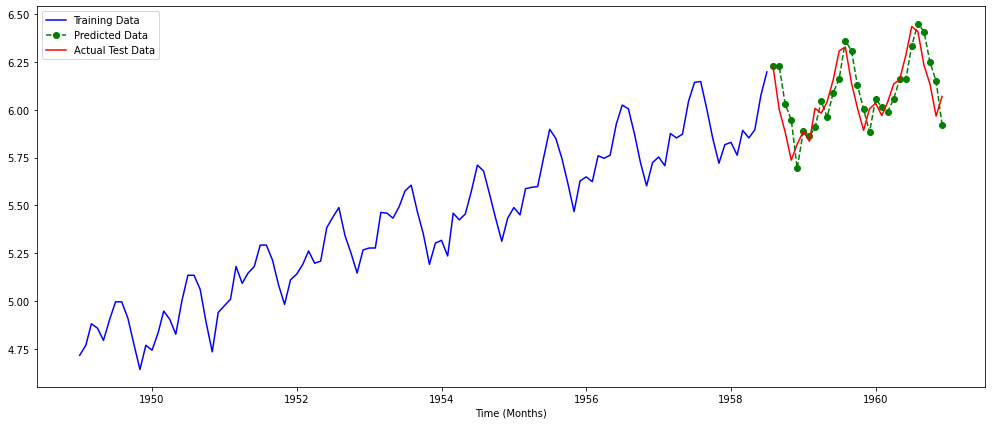

In [ ]:
# Visualize predictions along with train and test data
plt.figure(figsize=(17,7))
plt.plot(train_data['Passengers'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green',marker='o', linestyle='dashed', label='Predicted Data')
plt.plot(test_data.index, test_data['Passengers'], color='red', label='Actual Test Data')
plt.legend()
plt.xlabel("Time (Months)")
plt.show()

## Apply SARIMA Model

**SARIMA Model order [(p, d, q) x (P, D, Q, S)]**

Seasonal Autoregressive Integrated Moving Average, SARIMA or **Seasonal ARIMA**, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component. It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series. There are three trend elements that require configuration.

They are the same as the ARIMA model; specifically:

* **p:** Trend autoregression order.
* **d:** Trend difference order.
* **q:** Trend moving average order.

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

* **P:** Seasonal autoregressive order.
* **D:** Seasonal difference order.
* **Q:** Seasonal moving average order.
* **S:** Seasonal order or the number of time steps for a single seasonal period.

### Check the seasonality of the time series data and determine S value

Hint: `pd.DataFrame.diff(12)`, `seasonal_decompose()` for differencing to oberserve seasonality for 1 year

In [ ]:
# Make the index a date time format
df.reset_index(inplace=True)
df.Month = pd.to_datetime(df.Month)
df.set_index('Month',inplace=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
# Split the data into ~80% train and ~20% test
train_ar = df['Passengers'][:int(len(df['Passengers'])*0.8)]
test_ar = df['Passengers'][int(len(df['Passengers'])*0.8):]

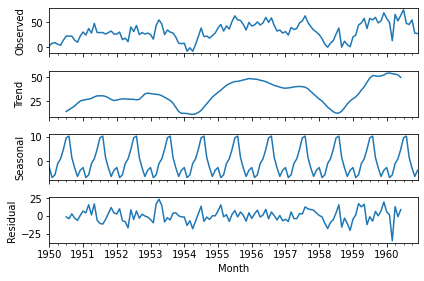

In [ ]:
# Differencing to observe seasonality for 1 year
data_diff_seas = df.diff(12)
data_diff_seas = data_diff_seas.dropna()
dec = seasonal_decompose(data_diff_seas)
dec.plot()
plt.show()

In the above plot, we can see that seasonality exists for every year (for 12 entries). So the seasonal order value, $S = 12$.

### Check stationarity for seasonal differenced series and select SARIMA seasonal parameters (P,D,Q) values

Hint:

- seasonal difference(T) = observation(T) – observation(T - 12)
    - If the seasonal difference is stationary then the D value will be 0. If not then compute the seasonal first difference and so on till it becomes stationary.
- seasonal first difference(T) = seasonal difference(T) – seasonal difference(T - 1)
- For P and Q values, use PACF and ACF plots of seasonal first difference series.

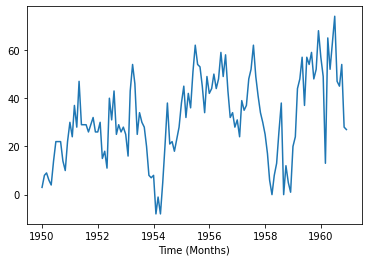

In [ ]:
# Visualize seasonally differenced time series
plt.plot(df['Passengers'].diff(12).dropna())
plt.xlabel("Time (Months)")
plt.show()

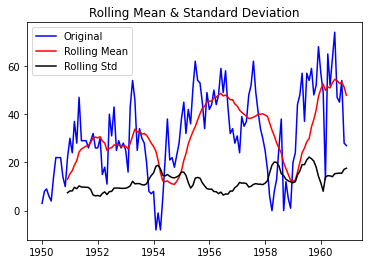

In [ ]:
# Check for stationarity
get_stationarity(df['Passengers'].diff(12).dropna())

In the above plot, the mean and standard deviation is changing with time hence the series is not stationary.

Now considering seasonal first difference to convert it to stationary series.

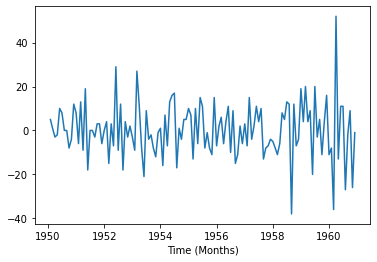

In [ ]:
# Visualize first order difference of seasonally differenced time series
plt.plot(df['Passengers'].diff(12).diff(1).dropna())
plt.xlabel("Time (Months)")
plt.show()

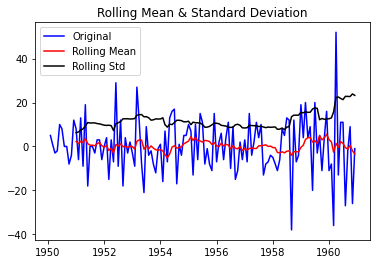

In [ ]:
# Check for stationarity
get_stationarity(df['Passengers'].diff(12).diff(1).dropna())

In the above plot, now the mean and standard deviation is more stable than before. Considering this as stationary time series, we have $S= 12$ and $D=1$.

Now, for $P$ and $Q$ values we can see PACF and ACF plots of seasonal first difference series.

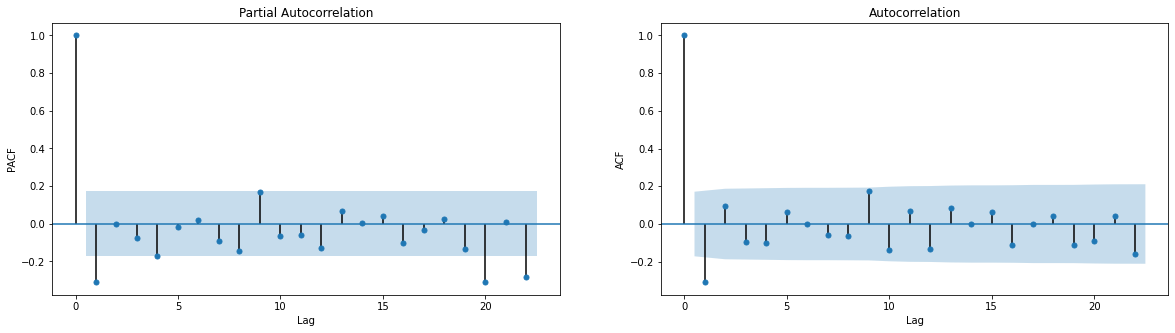

In [ ]:
# Visualize PACF and ACF plots
fig, ax = plt.subplots(1,2, figsize=(20, 5))
fig = plot_pacf(df['Passengers'].diff(12).diff(1).dropna(), lags=22, ax=ax[0]);ax[0].set_xlabel("Lag");ax[0].set_ylabel("PACF");
fig = plot_acf(df['Passengers'].diff(12).diff(1).dropna(), lags=22, ax=ax[1]);ax[1].set_xlabel("Lag");ax[1].set_ylabel("ACF");
plt.show()

From the above plots, we can select P and Q values as 1 and 1 respectively. Also, as there is a sharp cut-off in both the plots and the autocorrelation is negative for ACF plot we increase the Q value by one. Now, we have $P=1$ and $Q=2$.

### Train the SARIMA Model

**Metric:** A metric that can be used to compare the relative quality of each model is AIC (Akaike information criterion), which is an estimator of out-of-sample prediction error; a lower AIC score indicates a more predictive model.

Hint: `sm.tsa.statespace.SARIMAX()`

Let's create a SARIMA model using the above order.

In [ ]:
warnings.filterwarnings("ignore")
# Define hyperparameters for ARIMA model
p, d, q, P, D, Q, S = 1, 1, 1, 1, 1, 2, 12
# Fit the SARIMA model
mod = sm.tsa.statespace.SARIMAX(train_ar, order=(p,d,q),seasonal_order=(P,D,Q,S),
                                enforce_stationarity=False, enforce_invertibility=False)
result = mod.fit()
print('ARIMA{}x{} - AIC:{}'.format((p,d,q), (P,D,Q), result.aic))

ARIMA(1, 1, 1)x(1, 1, 2) - AIC:571.6453302397987


We can also fine-tune the model if needed by trying different order values and check for their AIC scores.

In [ ]:
# Define multiple hyperparameters values for ARIMA model
p, d, q, P, D, Q, S = 1, (0,1), 1, (1,2), 1, 2, 12
# Fit the SARIMA model
for each_d in d:
    for each_P in P:
        mod = sm.tsa.statespace.SARIMAX(train_ar, order=(p,each_d,q),seasonal_order=(each_P,D,Q,S),
                                        enforce_stationarity=False, enforce_invertibility=False)
        results = mod.fit()
        print('ARIMA{}x{} - AIC:{}'.format((p,each_d,q), (each_P,D,Q), results.aic))

ARIMA(1, 0, 1)x(1, 1, 2) - AIC:578.9163014437044
ARIMA(1, 0, 1)x(2, 1, 2) - AIC:580.9122284704596
ARIMA(1, 1, 1)x(1, 1, 2) - AIC:571.6453302397987
ARIMA(1, 1, 1)x(2, 1, 2) - AIC:577.7820579430872


### Predict and visualize the test data using SARIMA Model

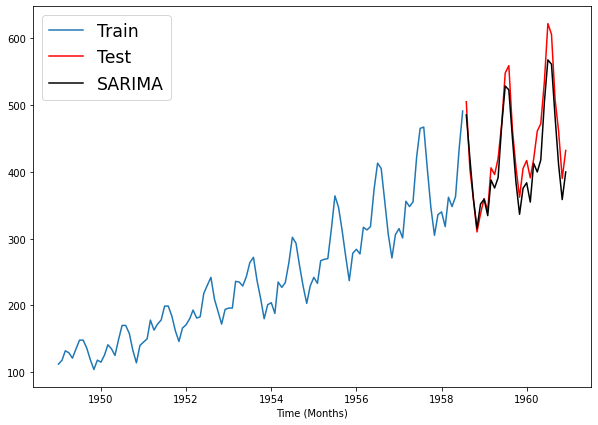

In [ ]:
# Prediction with SARIMA model
sarima_pred = result.predict(start=test_ar.index[0], end=test_ar.index[-1])

# Visualize the results
plt.figure(figsize=(10, 7))
plt.plot(train_ar.index, train_ar.values, label='Train')
plt.plot(test_ar.index, test_ar.values, label='Test', color='r')
plt.plot(sarima_pred.index, sarima_pred, label='SARIMA', color='k')
plt.legend(loc='best', fontsize='xx-large')
plt.xlabel("Time (Months)")
plt.show()

**References for Further Reading:**

[ACF and PACF plots](https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8#:~:text=ACF%20is%20an%20(complete)%20auto,related%20with%20its%20past%20values)

[ARIMA model](https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7)

[Interpret ACF and PACF plots](https://towardsdatascience.com/time-series-from-scratch-autocorrelation-and-partial-autocorrelation-explained-1dd641e3076f)

